Importing library

In [1]:
import os
from astropy.io import fits
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
from tensorflow_probability.python.distributions import kl_divergence

In [4]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Importing data

In [6]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/extra_files/five_band_image127x127_full.hdf5', 'r')

In [7]:
n = 5000

In [8]:
x = hf["image"][0:n]
y = hf["specz"][0:n]

In [9]:
x = np.transpose(x,(0,2,3,1))

In [10]:
## check this
max_value = np.max(x)
max_value

1108.394

In [11]:
x_new = np.true_divide(x,max_value)

In [12]:
hf.close()

Image Augmentation

In [13]:
##datagen = ImageDataGenerator(rotation_range=90)
##it = datagen.flow(x_new, batch_size=1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,test_size=0.2)

In [15]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [16]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 1e-3*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [18]:
from sklearn.model_selection import train_test_split



model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(127,127,5)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(Flatten())
model.add(tfpl.DenseVariational(512, activation='relu', input_shape=(5,), make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n))
model.add(tfpl.DenseVariational(128, activation='relu', input_shape=(5,), make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n))
model.add(Dense(2))
model.add(tfpl.IndependentNormal(1))



#model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])


model.summary()

model = Sequential([
    tf.keras.Input(shape=(127,127,5),name="basket"),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.Flatten(),
    # tfp.layers.DenseVariational(512, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(512, activation='tanh'),
    # tfp.layers.DenseVariational(128, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(128, activation='tanh'),
    Dense(2),
    tfp.layers.IndependentNormal(1)
])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 125, 125, 32)      1472      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 23328)            

NameError: name 'kl_divergence_function' is not defined

In [18]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model.compile(optimizer='Adam', loss = negative_loglikelihood)

In [ ]:
model.fit(x = x_train, y = y_train, epochs = 300, shuffle = True, verbose=1)

Epoch 1/300


In [133]:
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(model(np.array([x_test[i]])).mean()[0][0])

y_test_prediction = np.asarray(y_test_prediction)

y_test_ = []

for i in range(len(y_test)):
    y_test_.append(y_test[i][0])

y_test_ = np.asarray(y_test_)

In [134]:
from photoz_utils import *
y_test_new = pd.Series(y_test_)
y_test_predict_new = pd.Series(y_test_prediction)
get_point_metrics(y_test_predict_new,y_test_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",1000,0.999532,-7.579539,-7.498347,1.12661,0.859532,0.097,1.0,149.483042


In [135]:
y_train_predict = model_variational.predict(x_train)
y_train_prediction = []

for i in range(len(y_train)):
    y_train_prediction.append(y_train_predict[i][0])

y_train_prediction = np.asarray(y_train_prediction)

y_train_ = []

for i in range(len(y_train)):
    y_train_.append(y_train[i][0])

y_train_ = np.asarray(y_train_)

In [136]:
from photoz_utils import *
y_train_new = pd.Series(y_train_)
y_train_predict_new = pd.Series(y_train_prediction)
get_point_metrics(y_train_predict_new,y_train_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",4000,0.997257,-9.420139,-10.483891,142.825534,134.67865,0.0505,0.9975,52982.887312


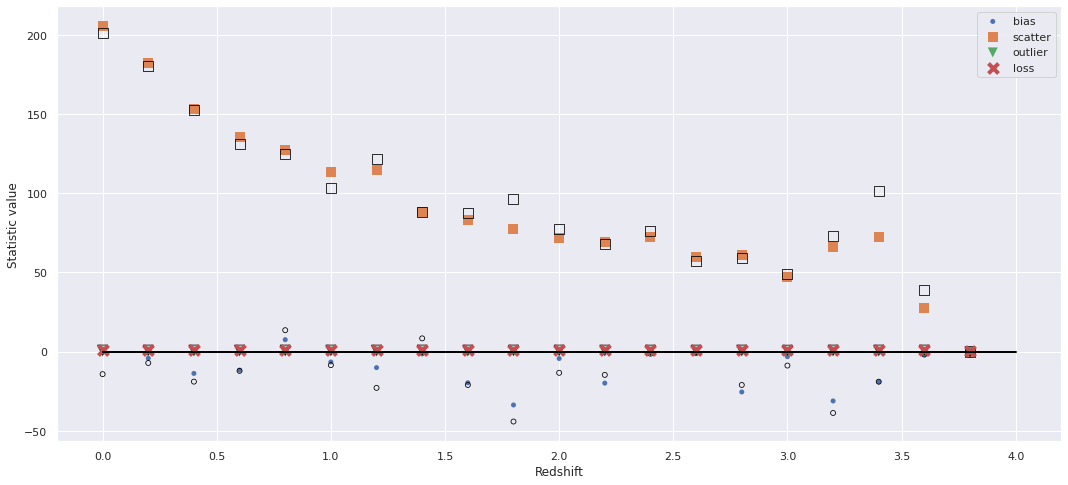

In [137]:
binned_metrics_train = get_point_metrics(y_train_predict_new,y_train_new,binned = True)
plot_point_metrics(binned_metrics_train)

In [138]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test_,y_test_prediction])
z = gaussian_kde(xy)(xy)

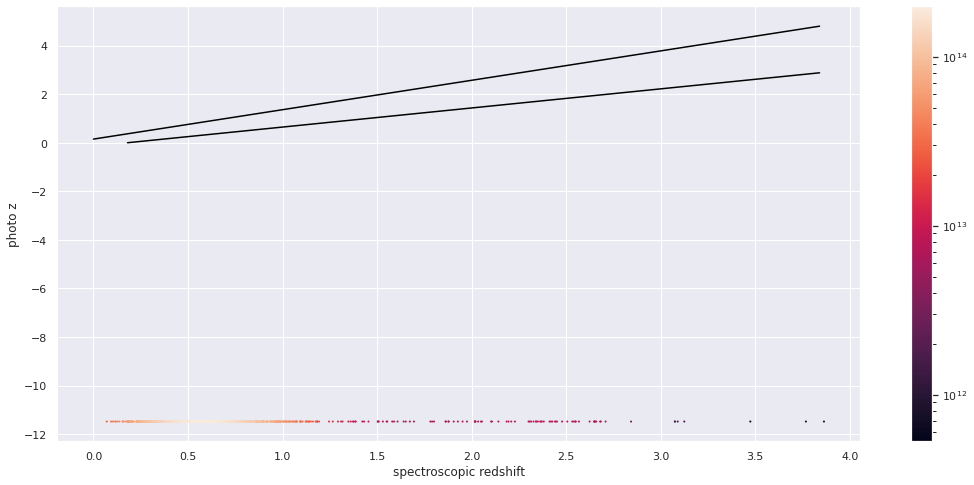

In [139]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(y_test, y_test_prediction, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')